In [ ]:
#BT vs SVGD_BT on Iris data. self supervised pretraining, then tune network on the embeddings

#Also, developed a novel algorithm that does the same thing. 

In [4]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import seaborn as sns
import numpy as np
from Base_Stein.SVGD_classes import *
import matplotlib.pyplot as plt


In [5]:
#Let's try on a really simple "toy" dataset. 

In [5]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

#Scale data to have mean 0 and variance 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Split the data set into training and testing

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,y,test_size=0.2,random_state=2)


X_view = X + np.random.uniform(low=-1.5,high=1.5,size=(150,4))

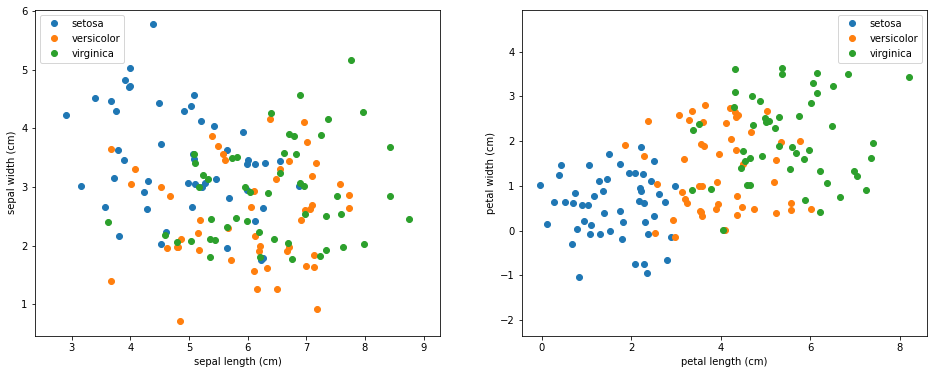

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
for target, target_name in enumerate(names):
    X_plot = X_view[y == target]
    ax1.plot(X_plot[:, 0], X_plot[:, 1], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax1.set_xlabel(feature_names[0])
ax1.set_ylabel(feature_names[1])
ax1.axis('equal')
ax1.legend();

for target, target_name in enumerate(names):
    X_plot = X_view[y == target]
    ax2.plot(X_plot[:, 2], X_plot[:, 3], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax2.set_xlabel(feature_names[2])
ax2.set_ylabel(feature_names[3])
ax2.axis('equal')
ax2.legend();

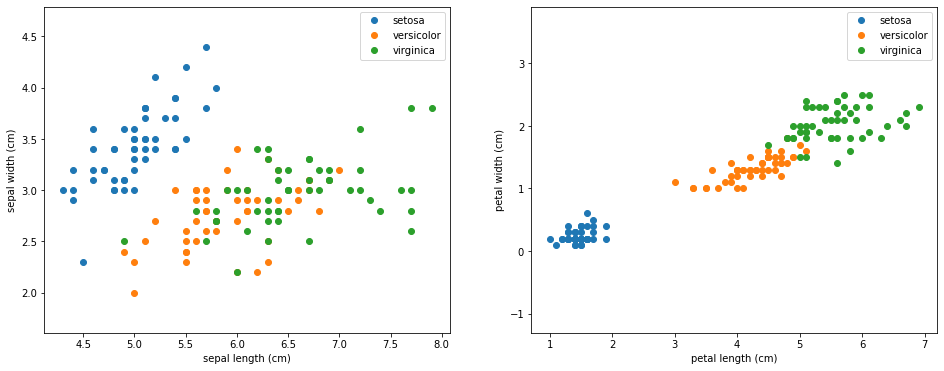

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    ax1.plot(X_plot[:, 0], X_plot[:, 1], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax1.set_xlabel(feature_names[0])
ax1.set_ylabel(feature_names[1])
ax1.axis('equal')
ax1.legend();

for target, target_name in enumerate(names):
    X_plot = X[y == target]
    ax2.plot(X_plot[:, 2], X_plot[:, 3], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax2.set_xlabel(feature_names[2])
ax2.set_ylabel(feature_names[3])
ax2.axis('equal')
ax2.legend();

In [7]:
#Basic embedding network
class Embed(nn.Module):
    
    def __init__(self,xdim,zdim):
        super().__init__()
        self.fc1 = nn.Linear(xdim,xdim)
        self.fc2 = nn.Linear(xdim,zdim)
        self.tanh = nn.Tanh()
        
    def forward(self,x):
        
        x=self.tanh(self.fc1(x))
        x=self.tanh(self.fc2(x))
        
        return x

In [8]:
class Project(nn.Module):
    
    def __init__(self,zdim):
        super().__init__()
        self.fc1 = nn.Linear(zdim,zdim)
        self.fc2 = nn.Linear(zdim,zdim)
        self.tanh = nn.Tanh()

    def forward(self,x):
        
        x=self.tanh(self.fc1(x))
        x=self.fc2(x)
        
        return x

In [226]:
#Implementation of BT

N=X_train.shape[0] #batch size
xdim=X_train.shape[1] #Input dimension
zdim=2 #representation size

embed = Embed(zdim=zdim,xdim=xdim)
project = Project(zdim=zdim)

optimizer = torch.optim.Adam(list(embed.parameters())+list(project.parameters()),lr=0.001)
#Say x sampled from uniform noise.


x = torch.tensor(X_train)
x=x.float()

print(x.shape)
input()

lambd=(zdim)/(zdim**2 - zdim)
#lambd=0.001
#lambd=1

EYE = torch.eye(zdim)

PSI = lambd*(torch.ones(zdim,zdim)-EYE) + EYE
#Get x1 and x2 by perturbation of x.
#x1 = x + 0.1*torch.rand(N,xdim)
#x2 = x + 0.1*torch.rand(N,xdim)

EPOCHS=4000
for epoch in range(EPOCHS):
    
    #Get x1 and x2 by perturbation of x.
    x1 = x + 3*torch.rand(120,4)-1.5
    x2 = x + 3*torch.rand(120,4)-1.5

    z1 = project(embed(x1))
    z2 = project(embed(x2))

    # normalize repr. along the batch dimension
    z1_norm = (z1 - z1.mean(0)) / z1.std(0) # NxD
    z2_norm = (z2 - z2.mean(0)) / z2.std(0) # NxD
    
    # cross-correlation matrix
    c = torch.mm(z1_norm.T, z2_norm) / N # DxD

    # loss
    c_diff = (c - EYE).pow(2) # DxD
    
    # multiply off-diagonal elems of c_diff by lambda, on diagonal by 1
    c_diff=PSI*c_diff
    
    loss = c_diff.sum()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


print(c)
print('{} Should be close to 1'.format(torch.min(torch.diag(c)))) #Should be close to 1
print('{} should be close to 0'.format(torch.max(torch.abs((torch.ones(zdim)-torch.eye(zdim))*c)))) #Should be close to zero






torch.Size([120, 4])


KeyboardInterrupt: Interrupted by user

In [203]:
#NEW tinkering. My adjustments to BT

embed = Embed(zdim=zdim,xdim=xdim)
project = Project(zdim=zdim)

optimizer = torch.optim.Adam(list(embed.parameters())+list(project.parameters()),lr=0.001)
#Say x sampled from uniform noise.

lambd1=(zdim)/(zdim**2 - zdim)

lambd1=1.0

lambd=0
#lambd=(zdim)/(zdim**2 - zdim)
#lambd=10

EYE = torch.eye(zdim)
PSI = lambd*(torch.ones(zdim,zdim)-EYE) + EYE

criterion = nn.MSELoss()

EPOCHS=300
for epoch in range(EPOCHS):
    
    #Get x1 and x2 by perturbation of x.
    x1 = x + 3*torch.rand(120,4)-1.5
    x2 = x + 3*torch.rand(120,4)-1.5

    z1 = project(embed(x1))
    z2 = project(embed(x2))

    # normalize repr. along the batch dimension
    z1_norm = (z1 - z1.mean(0)) / z1.std(0)# NxD
    z2_norm = (z2 - z2.mean(0)) / z2.std(0) # NxD
    
    z1_norm_s = torch.unsqueeze(z1_norm,dim=-1)
    z2_norm_s = torch.unsqueeze(z2_norm,dim=-1)
    
    Particles_1 = torch.cat((z1_norm_s[:,0],z2_norm_s[:,1]),dim=1) #so like (feature_1,feature_2)
    Particles_2 = torch.cat((z1_norm_s[:,1],z2_norm_s[:,0]),dim=1) #so like (feature_2,feature_1)
    
    svgd_1 = trainable_SVGD(N=N,zdim=zdim,eta=0.01)
    svgd_1.Particles = Particles_1.detach()
    
    svgd_2 = trainable_SVGD(N=N,zdim=zdim,eta=0.01)
    svgd_2.Particles = Particles_2.detach()
    
    #Inner loop
    for l in range(20):
    
        g = svgd_1.get_gradient() # "Like forward"
        svgd_1.AdamStep(gradient=g) #"Like step"
        #svgd_1.SgdStep(gradient=g)
        
        g = svgd_2.get_gradient() # "Like forward"
        svgd_2.AdamStep(gradient=g) #"Like step"
        #svgd_2.SgdStep(gradient=g)

    
    loss_1 = criterion(Particles_1,svgd_1.Particles)
    loss_2 = criterion(Particles_2,svgd_2.Particles)
    
    loss_3 = loss_1+loss_2
    
    # cross-correlation matrix
    c = torch.mm(z1_norm.T, z2_norm) / N # DxD
    
    # loss
    c_diff = (c - EYE).pow(2) # DxD
    
    # multiply off-diagonal elems of c_diff by lambda, on diagonal by 1
    c_diff=PSI*c_diff
    
    loss = c_diff.sum() + lambd1*loss_3

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


print('{} Should be close to 1'.format(torch.min(torch.diag(c)))) #Should be close to 1
print('{} should be close to 0'.format(torch.max(torch.abs((torch.ones(zdim)-torch.eye(zdim))*c)))) #Should be close to zero



0.6396743655204773 Should be close to 1
0.34453922510147095 should be close to 0


In [204]:
#Now, train a classifier on the embedding!

class Classifier(nn.Module):
    
    def __init__(self,zdim):
        super().__init__()
        self.fc1 = nn.Linear(zdim,zdim)
        self.fc2 = nn.Linear(zdim,4)
        self.tanh = nn.Tanh()
        
    def forward(self,x):
        x = self.tanh(self.fc1(x))
        x = F.softmax(self.fc2(x),dim=1)
        return x
        

In [431]:
#Now train classifier on the training data using the embedding
model = Classifier(zdim=zdim)

m = nn.Linear(zdim,zdim)

optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()
EPOCHS = 10000
loss_list = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

y = torch.tensor(y_train)

for epoch in range(EPOCHS):
    
    z = embed(x)

    y_pred = model(z)
    
    loss = criterion(y_pred,y)
    loss_list[epoch] = loss.item()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #Record accuracy on training (or test?) set
    with torch.no_grad():
        y_pred = model(z)
        correct = (torch.argmax(y_pred,dim=1) == y).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()
        
        
print(accuracy_list[EPOCHS-10:EPOCHS-1])

[0.96666664 0.96666664 0.96666664 0.96666664 0.96666664 0.96666664
 0.96666664 0.96666664 0.96666664]


In [296]:
class Discrim(nn.Module):
    def __init__(self,zdim):
        super().__init__()
        self.fc1 = nn.Linear(zdim,zdim)
        self.fc2 = nn.Linear(zdim,2)
        self.tanh = nn.Tanh()
        
    def forward(self,x):
        x = self.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

In [301]:
target = torch.empty(3, dtype=torch.long).random_(5)

target0 = torch.tensor([0],dtype=torch.long)
target1 = torch.tensor([0],dtype=torch.long)



inpu = torch.randn(1,2, requires_grad=True)

criterion(inpu,target)



ValueError: Expected input batch_size (1) to match target batch_size (3).

In [315]:
x[torch.randperm(120),:]

tensor([[-1.7367e-01,  3.0908e+00, -1.2834e+00, -1.0522e+00],
        [ 1.0380e+00,  5.5861e-01,  1.1038e+00,  1.1856e+00],
        [ 3.1100e-01, -1.3198e-01,  4.7857e-01,  2.6414e-01],
        [ 5.5333e-01, -1.2830e+00,  7.0592e-01,  9.2230e-01],
        [-4.1601e-01, -1.5132e+00, -3.2966e-02, -2.6239e-01],
        [-7.7951e-01,  7.8881e-01, -1.3402e+00, -1.3154e+00],
        [ 6.7450e-01, -5.9237e-01,  1.0469e+00,  1.3172e+00],
        [ 5.5333e-01, -8.2257e-01,  6.4908e-01,  7.9067e-01],
        [ 6.7450e-01,  9.8217e-02,  9.9011e-01,  7.9067e-01],
        [-9.0068e-01,  1.0190e+00, -1.3402e+00, -1.3154e+00],
        [-1.0218e+00,  1.0190e+00, -1.3971e+00, -1.1838e+00],
        [-1.7489e+00, -3.6218e-01, -1.3402e+00, -1.3154e+00],
        [ 1.4015e+00,  3.2841e-01,  5.3541e-01,  2.6414e-01],
        [ 5.5333e-01,  7.8881e-01,  1.0469e+00,  1.5805e+00],
        [ 5.5333e-01, -3.6218e-01,  1.0469e+00,  7.9067e-01],
        [ 2.2497e+00, -1.3198e-01,  1.3311e+00,  1.4488e+00],
        

In [429]:
model = Discrim(zdim=zdim)
inner_optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

embed = Embed(zdim=zdim,xdim=xdim)
project = Project(zdim=zdim)
outer_optimizer = torch.optim.Adam(list(embed.parameters())+list(project.parameters()),lr=0.001)

criterion = nn.CrossEntropyLoss()

for epoch in range(200):
    
    X=x[torch.randperm(120),:]
    
    loss=0
    meta_loss=0
    for i in range(118):

        X_ = X[i]
        A_ = X[i+1]
        
        x1 = X_ + 3*torch.rand(1,4)-1.5
        x2 = X_ + 3*torch.rand(1,4)-1.5
        
        a1 = A_ + 3*torch.rand(1,4)-1.5
        a2 = A_ + 3*torch.rand(1,4)-1.5
        
        #Dataset z, Dz
        z1 = project(embed(x1)).detach()
        z2 = project(embed(a1)).detach()
        
        #Dataset y, Dy
        y1 = project(embed(x2))
        y2 = project(embed(a2))
        
        #Inner adaptation
        for k in range(2):
            loss=(criterion(model(z1),target0) + criterion(model(z2),target1))
            inner_optimizer.zero_grad()
            loss.backward()
            inner_optimizer.step()
        
        meta_loss = criterion(model(y1),target0) + criterion(model(y2),target0)
        
        #Outer adaptation
        outer_optimizer.zero_grad()
        meta_loss.backward()
        outer_optimizer.step()
        
    #print(1000*meta_loss)

print('done')
        

done


In [293]:
-torch.log(torch.tensor([[torch.exp(-0.3205)]]))

tensor([[0.0101]])